this notebook only exists to prototpye code before it goes in .py files

In [3]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from dask.distributed import Client, LocalCluster
import xarray as xr
client = Client()
client

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 47433 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:47077 Dashboard: http://127.0.0.1:47433/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


In [1]:
from jetstream.post_proc import SingleModelPostProcessor
import os

In /home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/afa

In [4]:
def main(path_processed,shortname,path_postproc,var_of_interest):
    #create class
    single = SingleModelPostProcessor(path_to_files=path_processed,
         path_to_save_files=path_postproc+shortname+var_of_interest,
         diagnostic_var=var_of_interest,
         season='DJF')
    #demean or shift
    if var_of_interest =='t_prime':
        filename=path_postproc+f'{shortname}_{var_of_interest}_demeaned.nc4'
        single.demean(single.dataset.t_prime).rename('dm_t_prime'
                                            ).to_netcdf(filename)
    elif var_of_interest == 'eff_lat':
        filename=path_postproc+f'{shortname}_{var_of_interest}_demeaned_shifted.nc4'
        single.demeaned_shift(single.dataset).rename(
            {var_of_interest: 'phi_eq_prime'
            }).to_netcdf(filename)

In [6]:
import xarray as xr
ds1 =  xr.open_mfdataset("/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_2019-12-01_2020-03-01_new.nc4",
                       chunks={'time': 1},
                       concat_dim='time')

In [13]:
import numpy as np
np.unique((ds1-ds).t_prime.compute())

array([0.])

In [39]:
import xarray as xr
def preprocess(ds):
    return ds.sortby('time')
path = '/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed'
full_data = xr.open_mfdataset(f'{path}/ds_1979_2021_lat_20_1D_renamed_t_prime_*.nc4',
                 preprocess=preprocess,
                 chunks={'time': 1},
                 )


In [40]:
def preprocess_mf(array):
    var = list(array.variables.keys())[-1]
    if var not in ['eff_lat','t_prime']:
        array = array.rename({var: 'eff_lat'})
        #array_filter = array.where(array.eff_lat != 0, drop=True) #to test if doesnt work: array.where
    #elif var == 't_prime':
        #array_filter = array.where(array.t_prime != 0, drop=True)
    array_sorted = array.sortby('time')
    return array_sorted

path = '/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed'
_full_dataset = xr.open_mfdataset(f'{path}/ds_1979_2021_lat_20_1D_renamed_eff_lat_*.nc4',
                                         chunks={'time': 1},
                                         concat_dim='time',
                                         preprocess=preprocess_mf)

In [43]:
comp = client.compute(_full_dataset)

In [37]:
_full_dataset.where(_full_dataset['eff_lat'] !=0).compute()

KeyboardInterrupt: 

In [52]:
from scipy.stats import skew
import numpy as np
skew([[0,1,1,1,1,3,4],[0,3,np.nan,3,4,2,5],[5,5,5,2,1,3,4]])

array([ 0.70710678,  0.        ,         nan,  0.        ,  0.70710678,
       -0.70710678,  0.70710678])

In [12]:
import pandas as pd
def sel_winters(data,start_year=2015,end_year=2100):
    winters = pd.date_range('%i-12-01'%start_year,'%i-02-28'%(start_year+1),freq='D')
    print(data.sel(time=winters))
    for i in range(start_year+1,end_year):
        begin = i 
        end = i+1 
        winters=winters.union(pd.date_range('%i-12-01'%begin,'%i-02-28'%end,freq='D'))
        print(data.sel(time=winters))
    selected = data.sel(time=winters)
    return selected
sel_winters(ds,*year_range)

<xarray.Dataset>
Dimensions:  (lat: 280, lon: 1440, time: 90)
Coordinates:
    expver   int32 1
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 1980-02-28
Data variables:
    t_ref    (time, lat, lon) float64 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
    t_prime  (time, lat, lon) float64 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (lat: 280, lon: 1440, time: 180)
Coordinates:
    expver   int32 1
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 1981-02-28
Data variables:
    t_ref    (time, lat, lon) flo

<xarray.Dataset>
Dimensions:  (lat: 280, lon: 1440, time: 1350)
Coordinates:
    expver   int32 1
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 1994-02-28
Data variables:
    t_ref    (time, lat, lon) float64 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
    t_prime  (time, lat, lon) float64 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (lat: 280, lon: 1440, time: 1440)
Coordinates:
    expver   int32 1
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 1995-02-28
Data variables:
    t_ref    (time, lat, lon) 

KeyError: "not all values found in index 'time'"

In [54]:
ds.time[ds.time.dt.year==1999]

<xarray.DataArray 'time' (time: 90)>
array(['1999-01-01T00:00:00.000000000', '1999-01-02T00:00:00.000000000',
       '1999-01-03T00:00:00.000000000', '1999-01-04T00:00:00.000000000',
       '1999-01-05T00:00:00.000000000', '1999-01-06T00:00:00.000000000',
       '1999-01-07T00:00:00.000000000', '1999-01-08T00:00:00.000000000',
       '1999-01-09T00:00:00.000000000', '1999-01-10T00:00:00.000000000',
       '1999-01-11T00:00:00.000000000', '1999-01-12T00:00:00.000000000',
       '1999-01-13T00:00:00.000000000', '1999-01-14T00:00:00.000000000',
       '1999-01-15T00:00:00.000000000', '1999-01-16T00:00:00.000000000',
       '1999-01-17T00:00:00.000000000', '1999-01-18T00:00:00.000000000',
       '1999-01-19T00:00:00.000000000', '1999-01-20T00:00:00.000000000',
       '1999-01-21T00:00:00.000000000', '1999-01-22T00:00:00.000000000',
       '1999-01-23T00:00:00.000000000', '1999-01-24T00:00:00.000000000',
       '1999-01-25T00:00:00.000000000', '1999-01-26T00:00:00.000000000',
       '1999-01-27T00:00:00.000000000', '1999-01-28T00:00:00.000000000',
       '1999-01-29T00:00:00.000000000', '1999-01-30T00:00:00.000000000',
       '1999-01-31T00:00:00.000000000', '1999-02-01T00:00:00.000000000',
       '1999-02-02T00:00:00.000000000', '1999-02-03T00:00:00.000000000',
       '1999-02-04T00:00:00.000000000', '1999-02-05T00:00:00.000000000',
       '1999-02-06T00:00:00.000000000', '1999-02-07T00:00:00.000000000',
       '1999-02-08T00:00:00.000000000', '1999-02-09T00:00:00.000000000',
       '1999-02-10T00:00:00.000000000', '1999-02-11T00:00:00.000000000',
       '1999-02-12T00:00:00.000000000', '1999-02-13T00:00:00.000000000',
       '1999-02-14T00:00:00.000000000', '1999-02-15T00:00:00.000000000',
       '1999-02-16T00:00:00.000000000', '1999-02-17T00:00:00.000000000',
       '1999-02-18T00:00:00.000000000', '1999-02-19T00:00:00.000000000',
       '1999-02-20T00:00:00.000000000', '1999-02-21T00:00:00.000000000',
       '1999-02-22T00:00:00.000000000', '1999-02-23T00:00:00.000000000',
       '1999-02-24T00:00:00.000000000', '1999-02-25T00:00:00.000000000',
       '1999-02-26T00:00:00.000000000', '1999-02-27T00:00:00.000000000',
       '1999-02-28T00:00:00.000000000', '1999-12-01T00:00:00.000000000',
       '1999-12-02T00:00:00.000000000', '1999-12-03T00:00:00.000000000',
       '1999-12-04T00:00:00.000000000', '1999-12-05T00:00:00.000000000',
       '1999-12-06T00:00:00.000000000', '1999-12-07T00:00:00.000000000',
       '1999-12-08T00:00:00.000000000', '1999-12-09T00:00:00.000000000',
       '1999-12-10T00:00:00.000000000', '1999-12-11T00:00:00.000000000',
       '1999-12-12T00:00:00.000000000', '1999-12-13T00:00:00.000000000',
       '1999-12-14T00:00:00.000000000', '1999-12-15T00:00:00.000000000',
       '1999-12-16T00:00:00.000000000', '1999-12-17T00:00:00.000000000',
       '1999-12-18T00:00:00.000000000', '1999-12-19T00:00:00.000000000',
       '1999-12-20T00:00:00.000000000', '1999-12-21T00:00:00.000000000',
       '1999-12-22T00:00:00.000000000', '1999-12-23T00:00:00.000000000',
       '1999-12-24T00:00:00.000000000', '1999-12-25T00:00:00.000000000',
       '1999-12-26T00:00:00.000000000', '1999-12-27T00:00:00.000000000',
       '1999-12-28T00:00:00.000000000', '1999-12-29T00:00:00.000000000',
       '1999-12-30T00:00:00.000000000', '1999-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    expver   int32 1
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31

In [28]:
var_of_interest = 'eff_lat'
path_data = '/project2/moyer/jetstream/era5_processed_data/'
path_postproc = '/scratch/midway2/afarah/jetstream/post_proc_output/' 
for model in ["ds_1950_1979_lat_20_1D_rename","ds_1979_2021_lat_20_1D_renamed"]: #os.listdir(path_data):
    print(model)
    path_processed = f'{path_data}{model}/{model}_{var_of_interest}*.nc4'
    shortname = 'era5'+model[2:12]
    print(shortname)
    main(path_processed,
         shortname,
         path_postproc,
        var_of_interest)


ds_1950_1979_lat_20_1D_rename
era5_1950_1979
1950-12-01 00:00:00 1975-02-28 00:00:00
<xarray.DataArray 'time' (time: 2256)>
array(['1950-12-01T00:00:00.000000000', '1950-12-02T00:00:00.000000000',
       '1950-12-03T00:00:00.000000000', ..., '1975-02-26T00:00:00.000000000',
       '1975-02-27T00:00:00.000000000', '1975-02-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1975-02-28
ds_1979_2021_lat_20_1D_renamed
era5_1979_2021
1979-12-01 00:00:00 2019-02-28 00:00:00
<xarray.DataArray 'time' (time: 3519)>
array(['1979-12-01T00:00:00.000000000', '1979-12-02T00:00:00.000000000',
       '1979-12-03T00:00:00.000000000', ..., '2019-02-26T00:00:00.000000000',
       '2019-02-27T00:00:00.000000000', '2019-02-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-02-28


KeyError: "not all values found in index 'time'"

In [5]:
var_of_interest = 't_prime'
path_data = '/project2/moyer/jetsream/cmip6_processed_data/'
path_postproc = '/scratch/midway2/afarah/jetstream/post_proc_output/' 
for model in os.listdir(path_data):
    if model in ['MRI-ESM2-0_hist_tas_daily','UKESM1-0-LL_ssp585_tas_daily']:
        continue
    path_processed = f'{path_data}{model}/{model}_{var_of_interest}*11*.nc4'
    shortname = model.split('-')[0]
    print(shortname)
    main(path_processed,
         shortname,
         path_postproc,
        var_of_interest)

MPI
CESM2
GFDL
IPSL


In [6]:
model='UKESM1-0-LL_ssp585_tas_daily'
path_processed = f'{path_data}{model}/{model}_{var_of_interest}*11*.nc4'
shortname = model.split('-')[0]
print(shortname)
main(path_processed,
     shortname,
     path_postproc,
    var_of_interest)

UKESM1


ValueError: Cannot convert date 2016-02-30 12:00:00 to a date in the standard calendar.  Reason: day is out of range for month.

In [24]:
single = SingleModelPostProcessor(path_to_files=path_processed,
         path_to_save_files=path_postproc+shortname+var_of_interest,
         diagnostic_var=var_of_interest,
         season='DJF')
single.dataset.t_prime.rename('lala')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.DataArray 'lala' (time: 3420, lat: 280, lon: 1440)>
dask.array<getitem, shape=(3420, 280, 1440), dtype=float64, chunksize=(1, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28

In [ ]:
filename = path_postproc+f'era5_{var_of_interest}_demeaned.nc4'
single.demean(single.dataset).rename({var_of_interest: 'dm_t_prime'}
                                            ).to_netcdf(filename)

In [44]:
comp.where(_comp['eff_lat'] !=0)

AttributeError: 'Future' object has no attribute 'where'

In [ ]:
import xarray as xr


test_shift = xr.open_dataset(filename,
                            chunks={'time': 1})

In [ ]:
test_shift.isel(time=0).dm_tprime.plot()

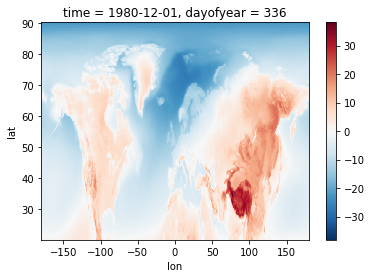

In [21]:
(single.dataset.isel(time=0).eff_lat - test_shift.isel(time=0).demeaned_shift).plot()